In [85]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
seq_length = 40
time_steps = np.linspace(0, 2 * np.pi, seq_length+1)
time_steps

array([0.        , 0.15707963, 0.31415927, 0.4712389 , 0.62831853,
       0.78539816, 0.9424778 , 1.09955743, 1.25663706, 1.41371669,
       1.57079633, 1.72787596, 1.88495559, 2.04203522, 2.19911486,
       2.35619449, 2.51327412, 2.67035376, 2.82743339, 2.98451302,
       3.14159265, 3.29867229, 3.45575192, 3.61283155, 3.76991118,
       3.92699082, 4.08407045, 4.24115008, 4.39822972, 4.55530935,
       4.71238898, 4.86946861, 5.02654825, 5.18362788, 5.34070751,
       5.49778714, 5.65486678, 5.81194641, 5.96902604, 6.12610567,
       6.28318531])

(41,)
(41, 1)


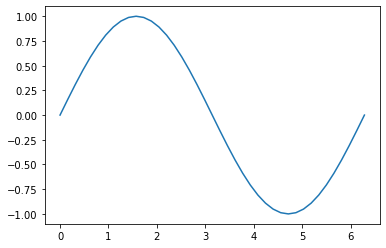

In [87]:
data = np.sin(time_steps)
print(data.shape)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
print(data.shape)
plt.plot(time_steps, data)

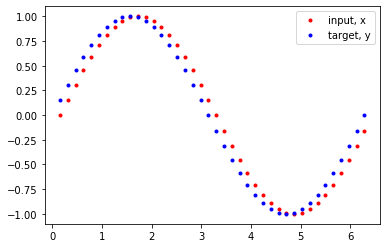

In [88]:
x = data[:-1] # all but the last data point
y = data[1:] # all but the first data point
plt.plot(time_steps[1:], x, 'r.', label='input, x')
plt.plot(time_steps[1:], y, 'b.', label='target, y')
plt.legend(loc='best')

---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [89]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden
        

In [90]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, 2*np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 40, 1])
Output size:  torch.Size([40, 1])
Hidden state size:  torch.Size([2, 1, 10])


---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [156]:
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [92]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.6427283883094788


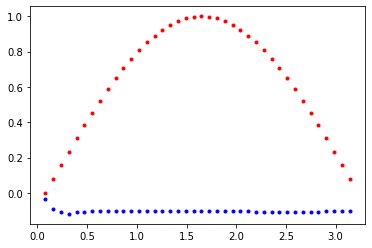

Loss:  0.023474302142858505


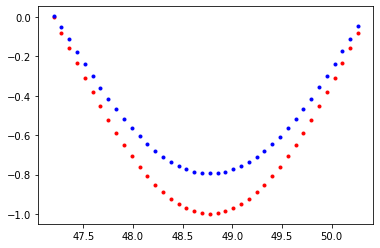

Loss:  0.0020200833678245544


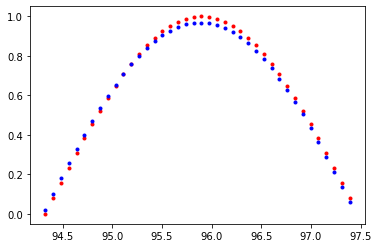

Loss:  0.001394998049363494


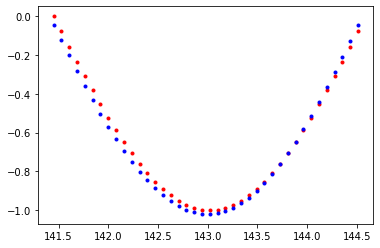

Loss:  0.0004018539621029049


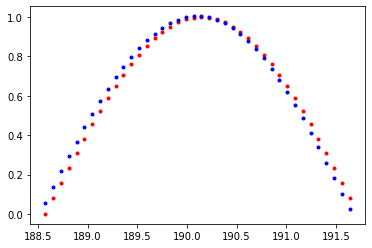

Loss:  0.00014299909526016563


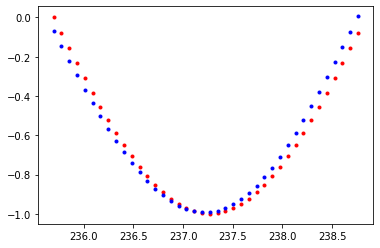

Loss:  3.30162001773715e-05


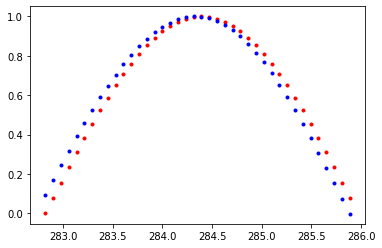

In [93]:
# train the rnn and monitor results
n_steps = 100
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

(41,)
(41, 1)


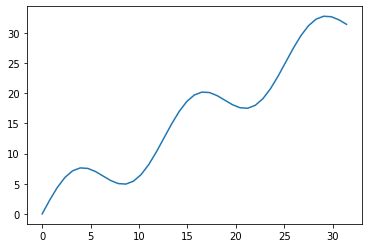

In [254]:
seq_length = 40
time_steps = np.linspace(0, 10 * np.pi, seq_length+1)
data = np.sin(time_steps/2)*4 + time_steps
print(data.shape)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
print(data.shape)
plt.plot(time_steps, data)

In [291]:
# train the RNN
# decide on hyperparameters
plt.clf()
input_size=1 
output_size=1
hidden_dim=256
n_layers=5

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    total_x = np.ndarray([])
    total_y = np.ndarray([])
    total_time = np.ndarray([])
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps/2)*4 + time_steps
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        
        total_time = np.concatenate((total_time, time_steps[:-1]), axis=None)
        total_x = np.concatenate((total_x, x.squeeze()), axis=None)
        total_y = np.concatenate((total_y, prediction.data.numpy().flatten()), axis=None)

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            #plt.plot(time_steps[1:], x, 'r.') # input
            #plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.plot(total_time, total_x, 'r.')
            plt.plot(total_time, total_y, 'b.')
            plt.show()

        # display loss and predictions
#         if batch_i%print_every == 0:        
#             print('Loss: ', loss.item())
#             plt.plot(time_steps[1:], x, 'r.') # input
#             plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
#             plt.show()
    
    return rnn

RNN(
  (rnn): RNN(1, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


<Figure size 432x288 with 0 Axes>

Loss:  22.008577346801758


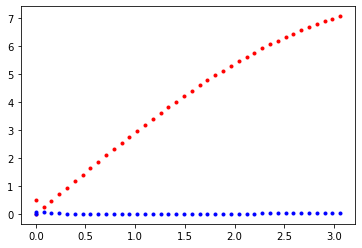

Loss:  264.0648498535156


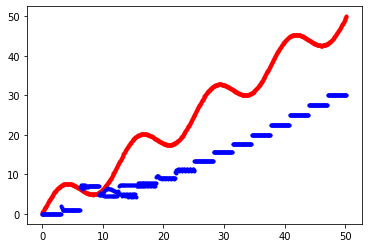

Loss:  413.1507568359375


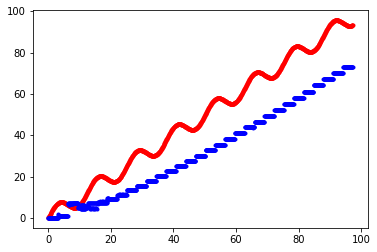

Loss:  752.9559326171875


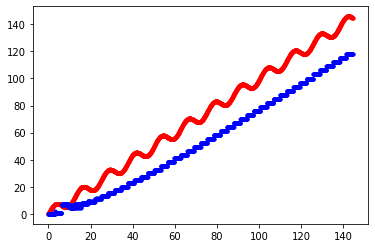

Loss:  858.7666015625


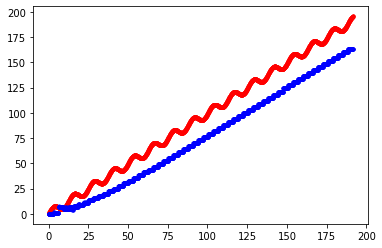

Loss:  662.9270629882812


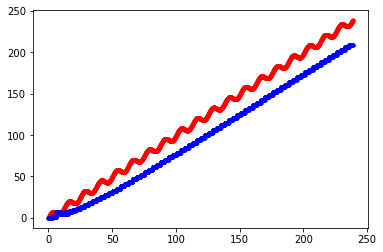

Loss:  724.133056640625


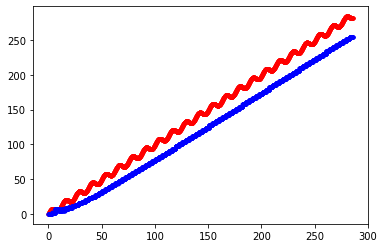

In [292]:
# train the rnn and monitor results
n_steps = 100
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [192]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        #self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.hidden = (torch.randn(n_layers, 1, hidden_dim),
                       torch.randn(n_layers, 1, hidden_dim))

    def forward(self, input_sequence):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = input_sequence.size(0)
        # get RNN outputs
        lstm_out, self.hidden = self.lstm(input_sequence, self.hidden)
        lstm_out = lstm_out.view(-1, self.hidden_dim)
        predictions = self.fc(lstm_out)
        
        return predictions

In [299]:
plt.clf()
# train the LSTM
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=256
n_layers=5

# instantiate an LSTM
lstm = LSTM(input_size, output_size, hidden_dim, n_layers)
print(lstm)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.1)

def train(lstm, n_steps, print_every):
    total_x = np.ndarray([])
    total_y = np.ndarray([])
    total_time = np.ndarray([])
    # initialize the hidden state
    for batch_i, step in enumerate(range(n_steps)):
        optimizer.zero_grad()
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps/2)*4 + time_steps
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the lstm
        prediction = lstm(x_tensor)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward(retain_graph=True)
        optimizer.step()
        
        total_time = np.concatenate((total_time, time_steps[:-1]), axis=None)
        total_x = np.concatenate((total_x, x.flatten()), axis=None)
        total_y = np.concatenate((total_y, prediction.data.numpy().flatten()), axis=None)

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            #plt.plot(time_steps[1:], x, 'r.') # input
            #plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.plot(total_time, total_x, 'r.')
            plt.plot(total_time, total_y, 'b.')
            plt.show()
            
        # display loss and predictions
#         if batch_i%print_every == 0:        
#             print('Loss: ', loss.item())
#             plt.plot(time_steps[1:], x, 'r.') # input
#             plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
#             plt.show()
    
    return lstm

LSTM(
  (lstm): LSTM(1, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


<Figure size 432x288 with 0 Axes>

Loss:  22.560256958007812


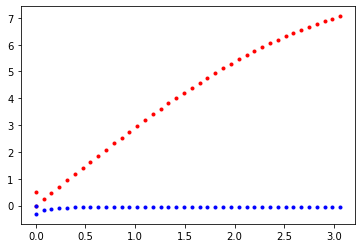

Loss:  26.724632263183594


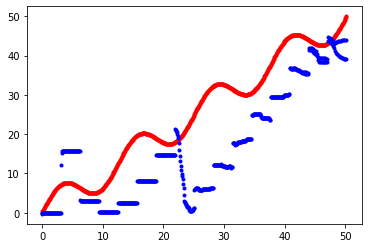

Loss:  7.093531131744385


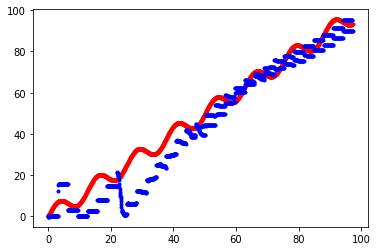

Loss:  31.114036560058594


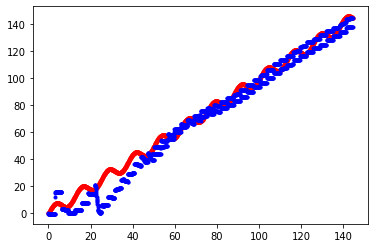

Loss:  3.9298908710479736


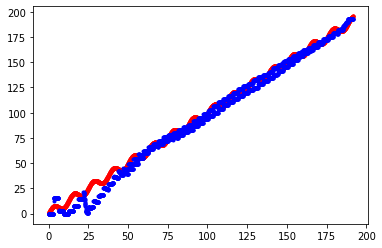

Loss:  44.0206184387207


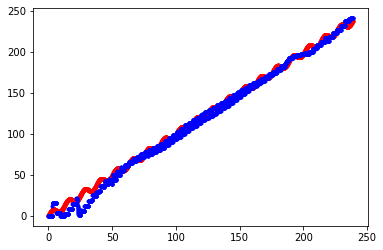

KeyboardInterrupt: 

In [300]:
# train the rnn and monitor results
n_steps = 100
print_every = 15

trained_rnn = train(lstm, n_steps, print_every)